## Adaptive optimizers

In this seminar you will implement a logistic regression and train it using stochastic gradient descent modifications, numpy and your brain.

In [1]:
#load our dakka
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline

## Two-dimensional classification

To make things more intuitive, let's solve a 2D classification problem with syntetic data.

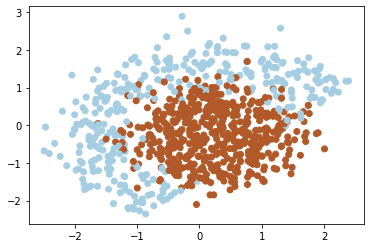

In [2]:
from sklearn import datasets, preprocessing

(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]

fig = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
fig.set_facecolor('xkcd:white')
plt.show()

In [3]:
print("X:\n{}\ny:\n{}".format(X[:3], y[:3]))

X:
[[0.98968126 1.68350033]
 [0.2888898  1.92693658]
 [1.91059302 1.12090994]]
y:
[0 0 0]


**Your task starts here**

Since the problem above isn't linearly separable, we add quadratic features to the classifier.

Implement this transformation in the __expand__ function __[1 point]__. 

In [4]:
def expand(X):
    """
    Adds quadratic features. 
    This function allows your linear model to make non-linear separation.
    
    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature1*feature2, 1]
    
    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """

    X_expanded = np.stack((X[:, 0], X[:, 1], X[:, 0]**2, X[:, 1]**2, X[:, 0] * X[:, 1], np.ones(X.shape[0])), axis=1)

    return X_expanded

In [5]:
#simple test on random numbers
#[all 8 random numbers are 100% random :P]
dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])

#call your expand function
dummy_expanded = expand(dummy_X)

#what it should have returned:   x0       x1       x0^2     x1^2     x0*x1    1
dummy_expanded_ans = np.array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
                               [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
                               [ 2.61  , -1.28  ,  6.8121,  1.6384, -3.3408,  1.    ],
                               [-0.59  ,  2.1   ,  0.3481,  4.41  , -1.239 ,  1.    ]])

#tests
assert isinstance(dummy_expanded,np.ndarray), "please make sure you return numpy array"
assert dummy_expanded.shape==dummy_expanded_ans.shape, "please make sure your shape is correct"
assert np.allclose(dummy_expanded,dummy_expanded_ans,1e-3), "Something's out of order with features"

print("Seems legit!")

Seems legit!


### Logistic regression (4 pts)
Now, let's write function that predicts class given $X$ as in logistic regression.

The math should look like this:

$$ P(y| \vec x, \vec w) = \sigma(\vec x \cdot \vec w ),$$

where $x$ represents features, $w$ are weights and $$\sigma(a) = {1 \over {1+e^{-a}}}$$

We shall omit $ \vec {arrows} $ in further formulae for simplicity.

In [6]:
def classify(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x), see description above
        
    __don't forget to expand X inside classify and other functions__
    
    :param X: feature matrix X of shape [n_samples,2] (non-exanded)
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """

    X_expanded = expand(X)
    sigma = lambda a: 1 / (1 + np.exp(-a))
    
    return sigma(X_expanded @ w)

In [7]:
#sample usage / test just as the previous one
dummy_weights = np.linspace(-1, 1, 6)

dummy_probs = classify(dummy_X, dummy_weights)

dummy_answers = np.array([0.73105858, 0.450166, 0.02020883, 0.59844257])

assert isinstance(dummy_probs,np.ndarray), "please return np.array"
assert dummy_probs.shape == dummy_answers.shape, "please return an 1-d vector with answers for each object"
assert np.allclose(dummy_probs,dummy_answers,1e-3), "There's something non-canonic about how probabilities are computed"

The loss you should try to minimize is the Logistic Loss aka crossentropy aka negative log-likelihood:

$$ L =  - {1 \over N} \sum_i {y_i \cdot log P(y_i|x_i,w) + (1-y_i) \cdot log (1-P(y_i|x_i,w))}$$

In [8]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector y [n_samples] of +1/0,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    return -np.sum(y @ np.log(classify(X, w)) + (1 - y) @ np.log(1 - classify(X, w))) / X.shape[0]

In [9]:
dummy_y = np.array([0,1,0,1])
dummy_loss = compute_loss(dummy_X, dummy_y, dummy_weights)

assert np.allclose(dummy_loss,0.66131), "something wrong with loss"

Since we train our model with gradient descent, we gotta compute gradients.

To be specific, we need a derivative of loss function over each weight [6 of them].

$$ \nabla L = {\partial L \over \partial w} = \frac{1}{N} X^\top \left(\sigma\left( X \omega \right) - y \right)$$

No, we won't be giving you the exact formula this time. Instead, try figuring out a derivative with pen and paper. 
x
As usual, we've made a small test for you, but if you need more, feel free to check your math against finite differences (estimate how L changes if you shift w by $10^{-5}$ or so).

In [10]:
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector y [n_samples] of +1/0,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    X_expanded = expand(X)
    sigma = lambda a: 1 / (1 + np.exp(-a))
    return X_expanded.T @ (sigma(X_expanded @ w) - y) / X_expanded.shape[0]

In [11]:
#tests
dummy_grads = compute_grad(dummy_X, dummy_y, dummy_weights)

#correct answers in canonic form
dummy_grads_ans = np.array([-0.06504252, -0.21728448, -0.1379879 , -0.43443953,  0.107504  , -0.05003101])

assert isinstance(dummy_grads,np.ndarray)
assert dummy_grads.shape == (6,), "must return a vector of gradients for each weight"
assert len(set(np.round(dummy_grads/dummy_grads_ans,3))), "gradients are wrong"
assert np.allclose(dummy_grads,dummy_grads_ans,1e-3), "gradients are off by a coefficient"

Here's an auxiliary function that visualizes the predictions

In [12]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """draws classifier prediction with matplotlib magic"""
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_facecolor('xkcd:white')

    ax1.contourf(xx, yy, Z, alpha=0.8)
    ax1.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    ax1.axis(xmin=xx.min(),xmax=xx.max())
    ax1.axis(ymin=yy.min(),ymax=yy.max())

    ax2.plot(history)
    ax2.grid()
    ymin, ymax = ax2.get_ylim()
    ax2.axis(ymin=0, ymax=ymax)

    display.clear_output(wait=True)
    plt.show()

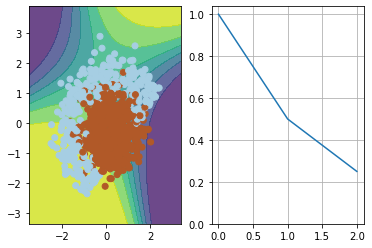

In [13]:
visualize(X,y,dummy_weights,[1,0.5,0.25])

### Training [1 point]
In this section, we'll use the functions you wrote to train our classifier using stochastic gradient descent.

Try to find an optimal learning rate for gradient descent for the given batch size. 

**Don't change the batch size!**

In [14]:
from sklearn.model_selection import train_test_split
X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [15]:
def simple_model(alpha, visual=False):
    w = np.array([0,0,0,0,0,1])
    n_iter = 50
    batch_size = 4
    loss = np.zeros(n_iter)
    val_loss = np.zeros(n_iter)

    if visual:
        fig = plt.figure(figsize=(12,5))
        fig.set_facecolor('xkcd:white')
    for i in range(n_iter):
        ind = np.random.choice(X.shape[0], batch_size)
        loss[i] = compute_loss(X, y, w)
        val_loss[i] = compute_loss(X_val, y_val, w)

        if visual:
            visualize(X[ind,:], y[ind], w, loss)

        w = w - alpha * compute_grad(X[ind,:], y[ind], w)

    if visual:
        visualize(X, y, w, loss)
        plt.clf()
        plt.show()

    return loss[-1], val_loss[-1]

In [16]:
alpha_grid = np.logspace(0.2, -4, num=100)
alpha_loss = np.zeros_like(alpha_grid)
alpha_val_loss = np.zeros_like(alpha_grid)

for i, alpha_i in enumerate(alpha_grid):
    t_loss = 0
    t_val_loss = 0
    for k in range(50):
        val1, val2 = simple_model(alpha_i)
        while np.isnan(val1) or np.isnan(val2):
            val1, val2 = simple_model(alpha_i)
        t_loss += val1
        t_val_loss += val2
    alpha_loss[i] = t_loss / 50
    alpha_val_loss[i] = t_val_loss / 50

In [17]:
def plot_res(param_ar, loss_ar, loss_val_ar, x_label='Learning rate'):
    fig = plt.figure(figsize=(12, 9))
    fig.set_facecolor('xkcd:white')
    plt.plot(param_ar, loss_ar, label='Train loss')
    plt.plot(param_ar, loss_val_ar, label='Validation loss')
    plt.ylabel('Loss')
    plt.xlabel(x_label)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

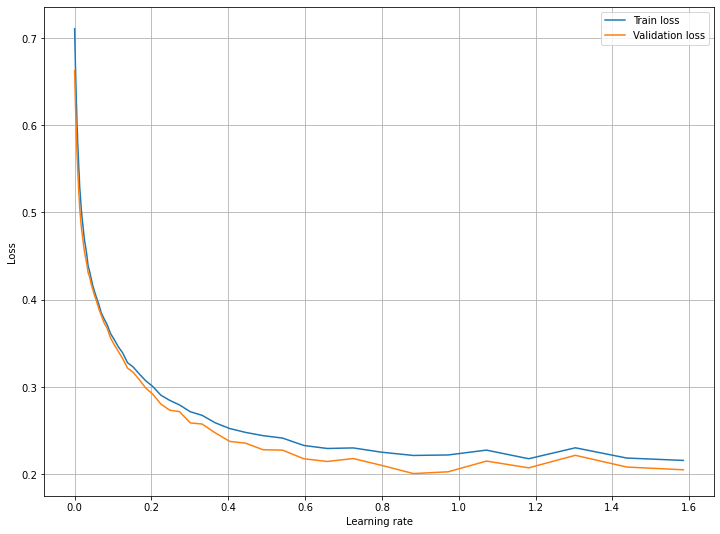

In [18]:
plot_res(alpha_grid, alpha_loss, alpha_val_loss)

In [19]:
alpha_opt = alpha_grid[alpha_val_loss.argmin()]
print('Optimal alpha: ', alpha_opt)

Optimal alpha:  0.881971487560358


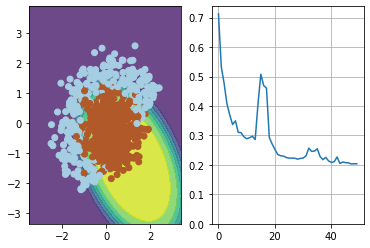

<Figure size 432x288 with 0 Axes>

(0.20365995059502065, 0.18316208644290483)

In [20]:
simple_model(alpha=alpha_opt, visual=True)

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values. __[2 points]__

In [21]:
def model_with_momentum(alpha, mu, visual=False):
    w     = np.array([0,0,0,0,0,1])
    h_vec = np.array([0,0,0,0,0,0])

    n_iter = 50
    batch_size = 4
    loss = np.zeros(n_iter)
    val_loss = np.zeros(n_iter)

    if visual:
        fig = plt.figure(figsize=(12,5))
        fig.set_facecolor('xkcd:white')
    for i in range(n_iter):
        ind = np.random.choice(X.shape[0], batch_size)
        loss[i] = compute_loss(X, y, w)
        val_loss[i] = compute_loss(X_val, y_val, w)

        if visual:
            visualize(X[ind,:], y[ind], w, loss)

        h_vec = mu * h_vec + alpha * compute_grad(X[ind,:], y[ind], w)
        w = w - h_vec

    if visual:
        visualize(X, y, w, loss)
        plt.clf()
        plt.show()

    return loss[-1], val_loss[-1]

In [28]:
alpha_num = 25
alpha_grid = np.logspace(0, -4, num=alpha_num)
alpha_loss = np.zeros_like(alpha_grid)

mu_num = 25
mu_grid = np.linspace(0.9, 0.01, num=mu_num)
mu_loss = np.zeros_like(mu_grid)

alpha_mu_loss = np.zeros((alpha_num, mu_num))
alpha_mu_val_loss = np.zeros((alpha_num, mu_num))

for i, alpha_i in enumerate(tqdm(alpha_grid)):
    for j, mu_j in enumerate(mu_grid):
        t_loss = 0
        t_val_loss = 0
        for k in range(10):
            val1, val2 = model_with_momentum(alpha_i, mu_j)
            while np.isnan(val1) or np.isnan(val2):
                val1, val2 = model_with_momentum(alpha_i, mu_j)
            t_loss += val1
            t_val_loss += val2
        alpha_mu_loss[i, j] = t_loss / 10
        alpha_mu_val_loss[i, j] = t_val_loss / 10

  0%|          | 0/25 [00:00<?, ?it/s]/Users/kgb/opt/anaconda3/envs/conda_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/kgb/opt/anaconda3/envs/conda_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in matmul
  
100%|██████████| 25/25 [01:29<00:00,  3.56s/it]


In [29]:
def heatplot(alpha_ar, param_ar, loss_ar, param_name='mu', title='Train'):
    fig, ax = plt.subplots()
    fig.set_facecolor('xkcd:white')

    loss_ar = loss_ar.T
    loss_ar = loss_ar[:-1, :-1]

    c = ax.pcolormesh(alpha_ar, param_ar, loss_ar, cmap='RdBu', vmin=loss_ar.min(), vmax=loss_ar.max())

    ax.axis([alpha_ar.min(), alpha_ar.max(), param_ar.min(), param_ar.max()])
    ax.set_title(title)

    cbar = fig.colorbar(c, ax=ax)
    cbar.ax.set_ylabel('Loss', rotation=-90, va="bottom")

    plt.xlabel('alpha')
    plt.ylabel(param_name)
    plt.show()

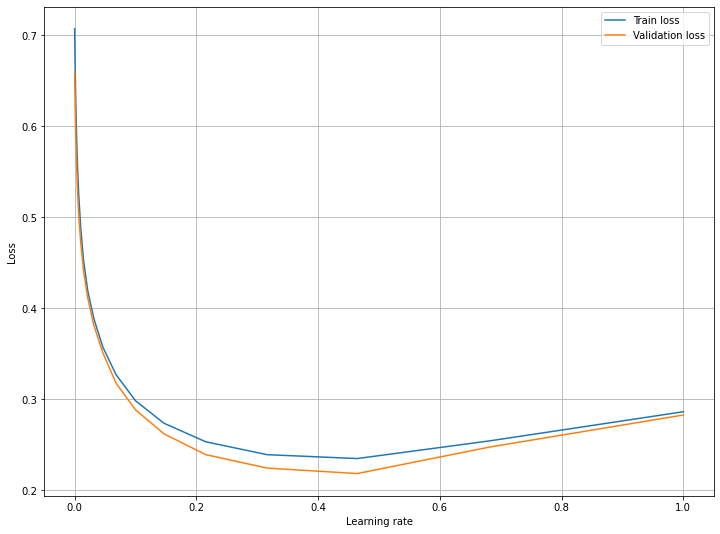

In [30]:
plot_res(alpha_grid, alpha_mu_loss.mean(axis=1), alpha_mu_val_loss.mean(axis=1))

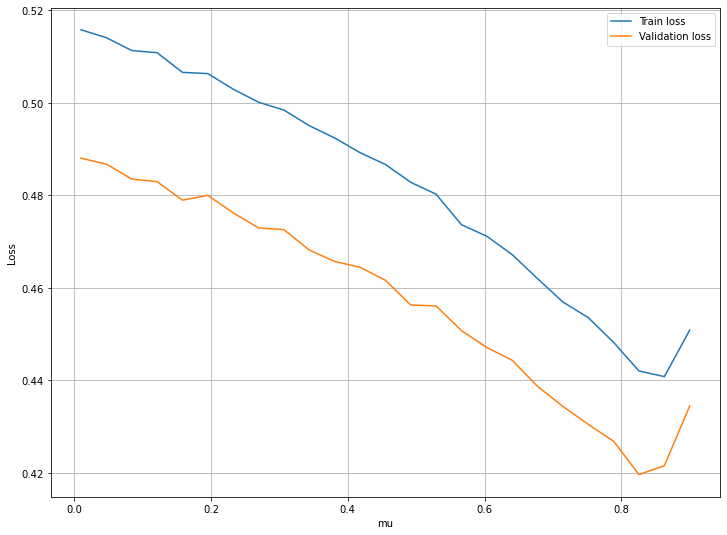

In [31]:
plot_res(mu_grid, alpha_mu_loss.mean(axis=0), alpha_mu_val_loss.mean(axis=0), x_label='mu')

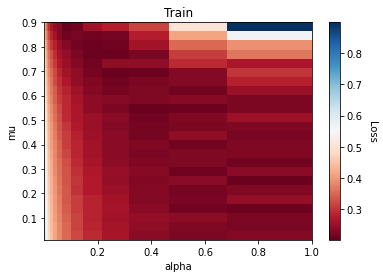

In [32]:
heatplot(alpha_grid, mu_grid, alpha_mu_loss)

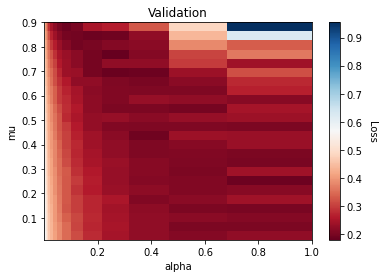

In [33]:
heatplot(alpha_grid, mu_grid, alpha_mu_val_loss, title='Validation')

In [35]:
alpha_ind, mu_ind = np.unravel_index(alpha_mu_val_loss.argmin(), alpha_mu_val_loss.shape)

alpha_opt = alpha_grid[alpha_ind]
mu_opt = mu_grid[mu_ind]

print('Optimal alpha: ', alpha_opt, '\n')
print('Optimal mu: ', mu_opt)

Optimal alpha:  0.31622776601683794 

Optimal mu:  0.7887500000000001


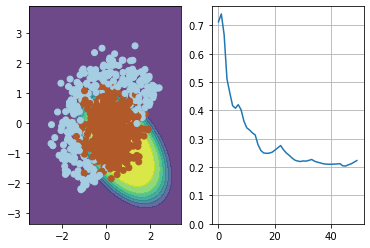

<Figure size 432x288 with 0 Axes>

(0.22325720853641176, 0.21173424899102128)

In [36]:
model_with_momentum(alpha=alpha_opt, mu=mu_opt, visual=True)

Implement RMSPROP algorithm __[2 points]__

In [37]:
def model_with_rmsprop(alpha, rho, visual=False):
    w = np.array([0,0,0,0,0,1])

    delta = 1e-6
    r = np.zeros_like(w)

    n_iter = 50
    batch_size = 4
    loss = np.zeros(n_iter)
    val_loss = np.zeros(n_iter)

    if visual:
        fig = plt.figure(figsize=(12,5))
        fig.set_facecolor('xkcd:white')

    for i in range(n_iter):
        ind = np.random.choice(X.shape[0], batch_size)
        loss[i] = compute_loss(X, y, w)
        val_loss[i] = compute_loss(X_val, y_val, w)

        if visual:
            visualize(X[ind,:], y[ind], w, loss)

        r = rho * r + (1 - rho) * compute_grad(X[ind,:], y[ind], w)**2
        w = w - alpha / np.sqrt(delta + r) * compute_grad(X[ind,:], y[ind], w)

    if visual:
        visualize(X, y, w, loss)
        plt.clf()
        plt.show()

    return loss[-1], val_loss[-1]

In [40]:
alpha_num = 25
alpha_grid = np.logspace(0, -4, num=alpha_num)
alpha_loss = np.zeros_like(alpha_grid)

rho_num = 25
rho_grid = np.linspace(0.9, 0.1, num=rho_num)
rho_loss = np.zeros_like(rho_grid)

alpha_rho_loss = np.zeros((alpha_num, rho_num))
alpha_rho_val_loss = np.zeros((alpha_num, rho_num))

for i, alpha_i in enumerate(tqdm(alpha_grid)):
    for j, rho_j in enumerate(rho_grid):
        t_loss = 0
        t_val_loss = 0
        for k in range(10):
            val1, val2 = model_with_rmsprop(alpha_i, rho_j)
            while np.isnan(val1) or np.isnan(val2):
                val1, val2 = model_with_rmsprop(alpha_i, rho_j)
            t_loss += val1
            t_val_loss += val2
        alpha_rho_loss[i, j] = t_loss / 10
        alpha_rho_val_loss[i, j] = t_val_loss / 10

  0%|          | 0/25 [00:00<?, ?it/s]/Users/kgb/opt/anaconda3/envs/conda_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
100%|██████████| 25/25 [01:44<00:00,  4.17s/it]


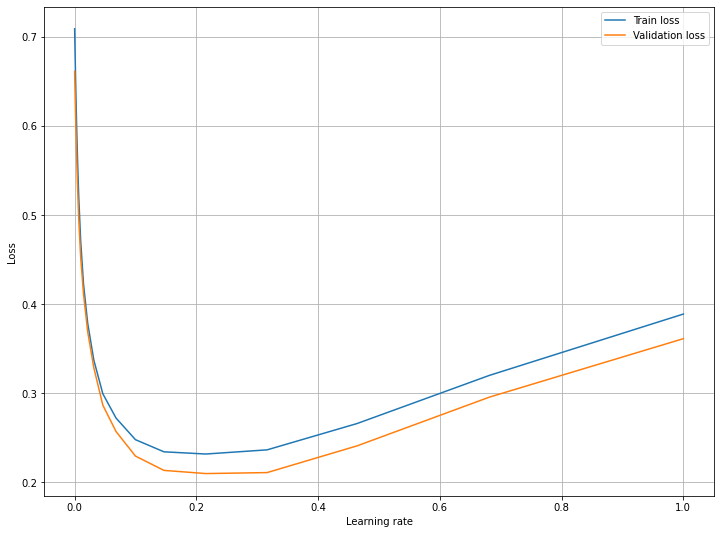

In [41]:
plot_res(alpha_grid, alpha_rho_loss.mean(axis=1), alpha_rho_val_loss.mean(axis=1))

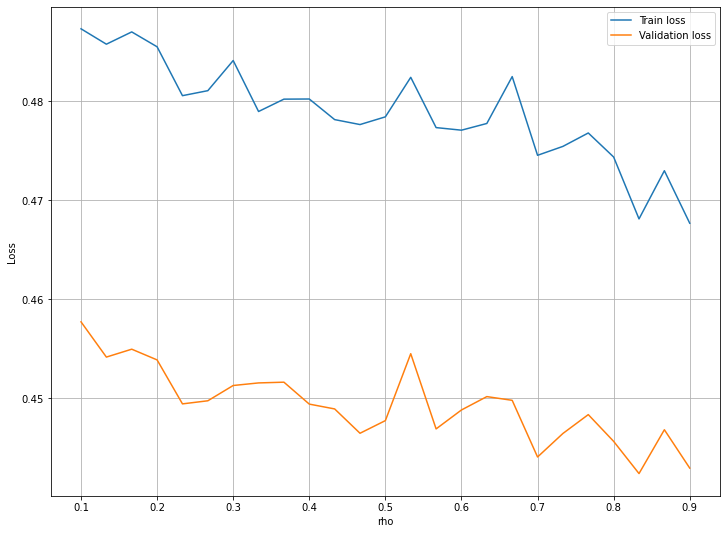

In [42]:
plot_res(rho_grid, alpha_rho_loss.mean(axis=0), alpha_rho_val_loss.mean(axis=0), x_label='rho')

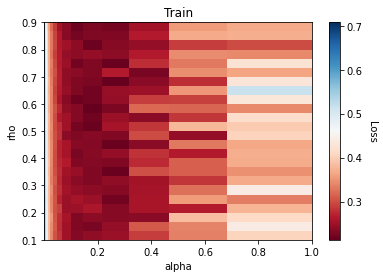

In [43]:
heatplot(alpha_grid, rho_grid, alpha_rho_loss, param_name='rho')

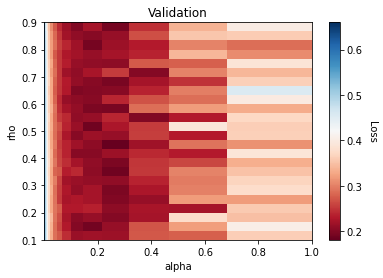

In [44]:
heatplot(alpha_grid, rho_grid, alpha_rho_val_loss, param_name='rho', title='Validation')

In [45]:
alpha_ind, rho_ind = np.unravel_index(alpha_rho_val_loss.argmin(), alpha_rho_val_loss.shape)
alpha_opt = alpha_grid[alpha_ind]
rho_opt = rho_grid[rho_ind]

print('Optimal alpha: ', alpha_opt, '\n')
print('Optimal rho: ', rho_opt)

Optimal alpha:  0.31622776601683794 

Optimal rho:  0.4666666666666667


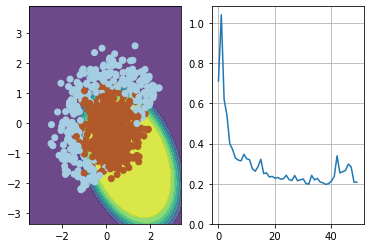

<Figure size 432x288 with 0 Axes>

(0.20831431871030773, 0.17990177069961852)

In [46]:
model_with_rmsprop(alpha=alpha_opt, rho=rho_opt, visual=True)

Which optimization method you consider the best? Type your answer in the cell below

Experience shows that among the considered algorithms, the most effective in training neural networks is RMSPROP.

# Bonus quest 
Try the same thing for Adagrad, Adam and anything else you find suitable.

_Each new adaptive optimizer is worth 2 points!_

## Adagrad

In [47]:
def model_with_adagrad(alpha, visual=False):
    w = np.array([0,0,0,0,0,1])

    delta = 1e-7
    r = np.zeros_like(w)

    n_iter = 50
    batch_size = 4
    loss = np.zeros(n_iter)
    val_loss = np.zeros(n_iter)

    if visual:
        fig = plt.figure(figsize=(12,5))
        fig.set_facecolor('xkcd:white')

    for i in range(n_iter):
        ind = np.random.choice(X.shape[0], batch_size)
        loss[i] = compute_loss(X, y, w)
        val_loss[i] = compute_loss(X_val, y_val, w)

        if visual:
            visualize(X[ind,:], y[ind], w, loss)

        r = r + compute_grad(X[ind,:], y[ind], w)**2
        w = w - alpha / (delta + np.sqrt(r)) * compute_grad(X[ind,:], y[ind], w)

    if visual:
        visualize(X, y, w, loss)
        plt.clf()
        plt.show()

    return loss[-1], val_loss[-1]

In [48]:
alpha_grid = np.logspace(0.3, -4, num=50)
alpha_loss = np.zeros_like(alpha_grid)
alpha_val_loss = np.zeros_like(alpha_grid)

for i, alpha_i in enumerate(alpha_grid):
    t_loss = 0
    t_val_loss = 0
    for k in range(10):
        val1, val2 = model_with_adagrad(alpha_i)
        while np.isnan(val1) or np.isnan(val2):
            val1, val2 = model_with_adagrad(alpha_i)
        t_loss += val1
        t_val_loss += val2
    alpha_loss[i] = t_loss / 10
    alpha_val_loss[i] = t_val_loss / 10

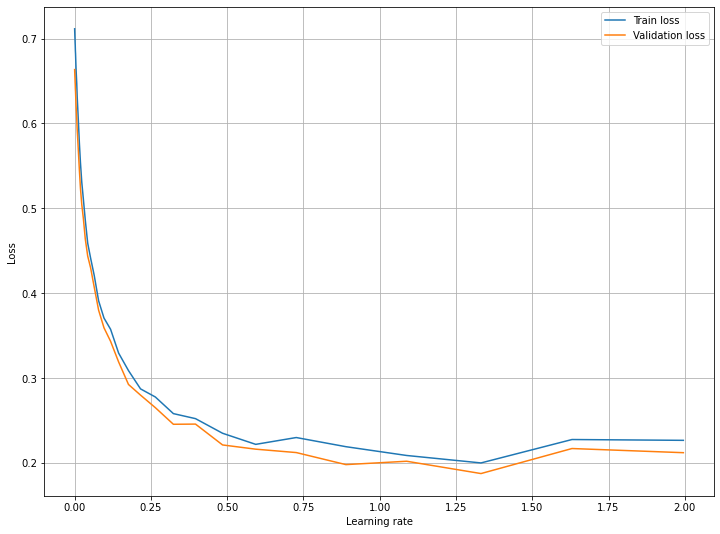

In [49]:
plot_res(alpha_grid, alpha_loss, alpha_val_loss)

In [50]:
alpha_opt = alpha_grid[alpha_val_loss.argmin()]

print('Optimal alpha: ', alpha_opt)

Optimal alpha:  1.3319557466246208


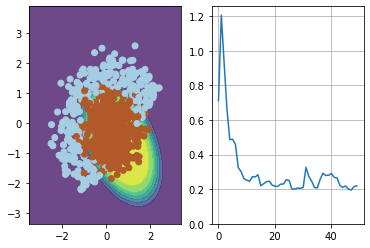

<Figure size 432x288 with 0 Axes>

(0.21977672366541076, 0.23867122779503971)

In [51]:
model_with_adagrad(alpha=alpha_opt, visual=True)

## Adam

In [52]:
def model_with_adam(alpha=0.001, rho1=0.9, rho2=0.999, visual=False):
    w = np.array([0,0,0,0,0,1])

    delta = 1e-8

    s = np.zeros_like(w)
    r = np.zeros_like(w)

    n_iter = 50
    batch_size = 4
    loss = np.zeros(n_iter)
    val_loss = np.zeros(n_iter)

    if visual:
        fig = plt.figure(figsize=(12,5))
        fig.set_facecolor('xkcd:white')

    for i in range(n_iter):
        ind = np.random.choice(X.shape[0], batch_size)
        loss[i] = compute_loss(X, y, w)
        val_loss[i] = compute_loss(X_val, y_val, w)

        if visual:
            visualize(X[ind,:], y[ind], w, loss)

        gradient = compute_grad(X[ind,:], y[ind], w)
        s = rho1 * s + (1 - rho1) * gradient
        r = rho2 * r + (1 - rho2) * gradient**2

        s_hat = s / (1 - rho1**(i + 1))
        r_hat = r / (1 - rho2**(i + 1))

        w = w - alpha * s_hat / (np.sqrt(r_hat) + delta)

    if visual:
        visualize(X, y, w, loss)
        plt.clf()
        plt.show()

    return loss[-1], val_loss[-1]

In [53]:
alpha_grid = np.logspace(0, -4, num=50)
alpha_loss = np.zeros_like(alpha_grid)
alpha_val_loss = np.zeros_like(alpha_grid)

for i, alpha_i in enumerate(alpha_grid):
    t_loss = 0
    t_val_loss = 0
    for k in range(10):
        val1, val2 = model_with_adam(alpha_i)
        while np.isnan(val1) or np.isnan(val2):
            val1, val2 = model_with_adam(alpha_i)
        t_loss += val1
        t_val_loss += val2
    alpha_loss[i] = t_loss / 10
    alpha_val_loss[i] = t_val_loss / 10

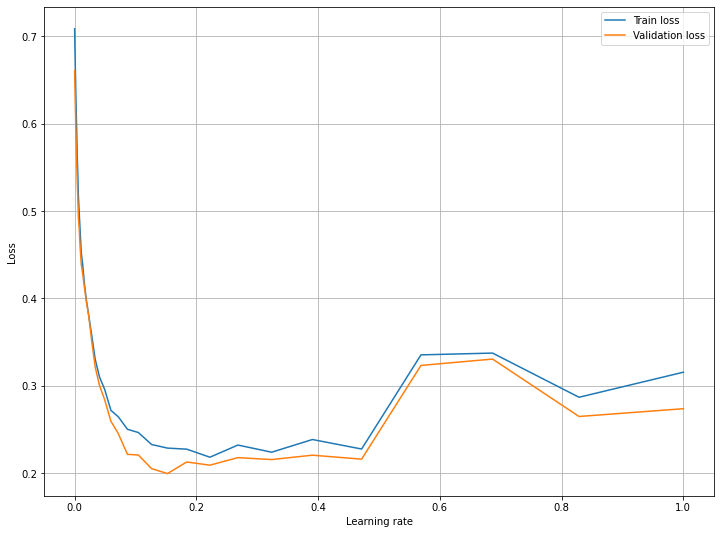

In [54]:
plot_res(alpha_grid, alpha_loss, alpha_val_loss)

In [55]:
alpha_opt = alpha_grid[alpha_val_loss.argmin()]

print('Optimal alpha: ', alpha_opt)

Optimal alpha:  0.15264179671752337


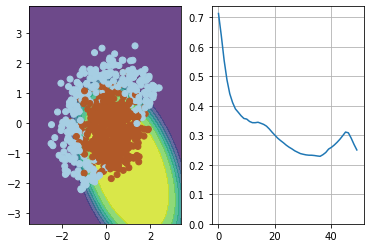

<Figure size 432x288 with 0 Axes>

(0.25023010254115335, 0.20096761463687096)

In [56]:
model_with_adam(alpha=alpha_opt, visual=True)